<a href="https://colab.research.google.com/github/AnastasiaKazanas/ANN-Final-Project/blob/main/BOW%E2%80%94FCNN_FakeNewsDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import random
import pandas as pd
import re
import nltk
import torch
import torch.nn as nn
import torch.optim as optim
from transformers import BertTokenizer, BertModel, BertForSequenceClassification
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import kagglehub
import os
import zipfile

In [ ]:
# Define the dataset directory
dataset_dir = "./fake_news_dataset"

# Create the dataset directory if it doesn't exist
if not os.path.exists(dataset_dir):
    os.makedirs(dataset_dir)

# Use Kaggle API to download the dataset
dataset_name = "emineyetm/fake-news-detection-datasets"
print(f"Downloading dataset: {dataset_name}")
os.system(f"kaggle datasets download -d {dataset_name} -p {dataset_dir}")

# Extract the dataset
zip_file = None
for file in os.listdir(dataset_dir):
    if file.endswith(".zip"):
        zip_file = os.path.join(dataset_dir, file)
        break

if not zip_file:
    raise FileNotFoundError("No zip file found in the dataset directory.")

print(f"Extracting {zip_file}...")
with zipfile.ZipFile(zip_file, "r") as zip_ref:
    zip_ref.extractall(dataset_dir)

# Dynamically locate Fake.csv and True.csv
fake_path, true_path = None, None
for root, dirs, files in os.walk(dataset_dir):
    for file in files:
        if "Fake.csv" in file:
            fake_path = os.path.join(root, file)
        if "True.csv" in file:
            true_path = os.path.join(root, file)

# Ensure the files are found
if not fake_path or not true_path:
    raise FileNotFoundError("Could not find Fake.csv or True.csv in the dataset directory.")

# Load datasets
fake_df = pd.read_csv(fake_path)
true_df = pd.read_csv(true_path)

# Add labels and combine datasets
fake_df['label'] = 0  # Fake news labeled as 0
true_df['label'] = 1  # True news labeled as 1
df = pd.concat([fake_df, true_df]).reset_index(drop=True)

# Display preview and statistics
print("Combined Dataset Preview:")
print(df.head())
print("\nDataset statistics:")
print(df.describe())

Extracting ./fake_news_dataset/fake-news-detection-datasets.zip...
Combined Dataset Preview:
                                               title  \
0   Donald Trump Sends Out Embarrassing New Year’...   
1   Drunk Bragging Trump Staffer Started Russian ...   
2   Sheriff David Clarke Becomes An Internet Joke...   
3   Trump Is So Obsessed He Even Has Obama’s Name...   
4   Pope Francis Just Called Out Donald Trump Dur...   

                                                text subject  \
0  Donald Trump just couldn t wish all Americans ...    News   
1  House Intelligence Committee Chairman Devin Nu...    News   
2  On Friday, it was revealed that former Milwauk...    News   
3  On Christmas day, Donald Trump announced that ...    News   
4  Pope Francis used his annual Christmas Day mes...    News   

                date  label  
0  December 31, 2017      0  
1  December 31, 2017      0  
2  December 30, 2017      0  
3  December 29, 2017      0  
4  December 25, 2017      0  

Data

In [ ]:
def preprocess_text(text):
    text = re.sub(r'[^\w\s]', '', text)  # Remove special characters
    text = text.lower()  # Convert to lowercase
    return text

df['processed_text'] = df['text'].apply(preprocess_text)

# Add filtering for texts with len < 50
new_data = []
new_labels = []
for text, label in zip(df['processed_text'], df['label']):
    if len(text) >= 50:  # Filter out texts shorter than 50 characters
        new_data.append(text)
        new_labels.append(label)

filtered_df = pd.DataFrame({'text': new_data, 'label': new_labels})

# Split the dataset
train_texts, test_texts, train_labels, test_labels = train_test_split(
    filtered_df['text'], filtered_df['label'], test_size=0.2, random_state=42
)


In [ ]:
# Tfidf Vectorization
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
X_train = vectorizer.fit_transform(train_texts).toarray()
X_test = vectorizer.transform(test_texts).toarray()

# Convert labels to tensors
train_labels = torch.tensor(train_labels.values, dtype=torch.long)
test_labels = torch.tensor(test_labels.values, dtype=torch.long)

# Create DataLoader
train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), train_labels)
test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32), test_labels)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)



In [ ]:
# Define the Neural Network
class TextClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(TextClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

input_dim = X_train.shape[1]
hidden_dim = 128
output_dim = 2

model = TextClassifier(input_dim, hidden_dim, output_dim)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training Loop
epochs = 10
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss:.4f}")

# Evaluation
model.eval()
y_pred = []
y_true = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        outputs = model(X_batch)
        _, preds = torch.max(outputs, 1)
        y_pred.extend(preds.numpy())
        y_true.extend(y_batch.numpy())


Epoch 1/10, Loss: 74.5921
Epoch 2/10, Loss: 8.1147
Epoch 3/10, Loss: 2.0748
Epoch 4/10, Loss: 0.7896
Epoch 5/10, Loss: 0.2392
Epoch 6/10, Loss: 0.1020
Epoch 7/10, Loss: 0.0510
Epoch 8/10, Loss: 0.0279
Epoch 9/10, Loss: 0.0149
Epoch 10/10, Loss: 0.0079



Model Accuracy: 1.00

Classification Report:
              precision    recall  f1-score   support

       False       1.00      0.99      1.00      4510
        True       0.99      1.00      1.00      4300

    accuracy                           1.00      8810
   macro avg       1.00      1.00      1.00      8810
weighted avg       1.00      1.00      1.00      8810



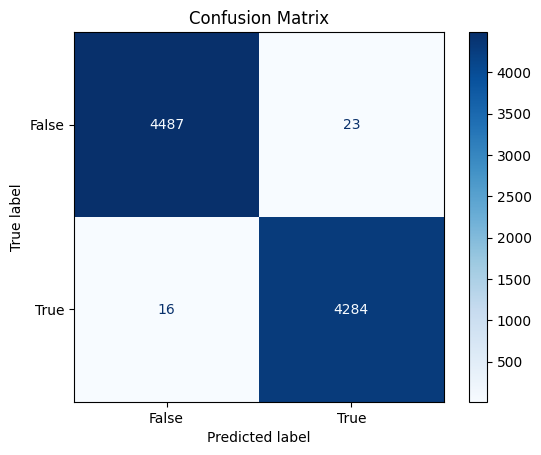


Sample Predictions:

Sample 1
Text: 21st century wire says after 12 months of perpetrating one of the greatest political hoaxes in history   blaming russia for the presidential victory of donald trump   the washington establishment is now wanting to take the lie to the next level by sanctioning not only russian international media outlets but any media outlet see one of their guide lists here who dare to violate the mainstream party line on the us war agenda by broadcasting to an america audience  forcing them the register as  foreign agents  under the fara act of 1934 crosstalk says  the television station you are watching now and the russian news agency sputnik may find themselves in legal jeopardy in the united states the drive to designate both as foreign agents under the  foreign agents registration act  is disturbing and dangerous it would seem those in power decide who can freely speak host peter lavelle is crosstalking with guests scott rickard neil clark and alexander nekrass

In [ ]:
accuracy = accuracy_score(y_true, y_pred)
print(f"\nModel Accuracy: {accuracy:.2f}")

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=['False', 'True']))

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(conf_matrix, display_labels=['False', 'True'])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

# Display a few predictions
print("\nSample Predictions:")
for i, (text, pred, true_label) in enumerate(zip(test_texts[:5], y_pred[:5], test_labels[:5])):
    print(f"\nSample {i+1}")
    print(f"Text: {text}")
    print(f"Predicted: {'True' if pred else 'False'}, Actual: {'True' if true_label else 'False'}")